# Install Dependencies and Setup

In [ ]:
!pip install tensorflow
!pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import tempfile

from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Loading Dataset

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
!git lfs install
!git clone https://huggingface.co/datasets/ebylmz/architects

Git LFS initialized.
Cloning into 'architects'...
remote: Enumerating objects: 1988, done.
remote: Counting objects: 100% (1984/1984), done.
remote: Compressing objects: 100% (1976/1976), done.
remote: Total 1988 (delta 7), reused 1984 (delta 7), pack-reused 4
Receiving objects: 100% (1988/1988), 278.57 KiB | 11.61 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (3160/3160), done.
Filtering content: 100% (3097/3097), 1.18 GiB | 52.61 MiB/s, done.


In [ ]:
from pathlib import Path
import shutil
import imghdr

data_dir = "/content/architects/scraping-clean-combined-top"
image_extensions = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            tip = imghdr.what(image_path)
            if tip not in image_extensions:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

Image not in ext list /content/architects/scraping-clean-combined-top/Mimar Kemalettin/00325.jpg
Image not in ext list /content/architects/scraping-clean-combined-top/Mimar Kemalettin/00120.jpg
Image not in ext list /content/architects/scraping-clean-combined-top/Mimar Kemalettin/00150.jpg
Image not in ext list /content/architects/scraping-clean-combined-top/Mimar Kemalettin/00136.jpg
Image not in ext list /content/architects/scraping-clean-combined-top/Mimar Kemalettin/00011.jpg
Image not in ext list /content/architects/scraping-clean-combined-top/Mimar Kemalettin/00021.jpg
Image not in ext list /content/architects/scraping-clean-combined-top/Mimar Kemalettin/00173.jpg
Image not in ext list /content/architects/scraping-clean-combined-top/Mimar Kemalettin/00274.jpg
Image not in ext list /content/architects/scraping-clean-combined-top/Mimar Kemalettin/00388.jpg
Image not in ext list /content/architects/scraping-clean-combined-top/Mimar Kemalettin/00309.jpg
Image not in ext list /content

In [ ]:
img_height, img_width = 224, 224
batch_size = 32
seed = 275

train_ds = tf.keras.utils.image_dataset_from_directory (
  data_dir,
  labels="inferred",
  color_mode="rgb",
  batch_size=batch_size,
  image_size=(img_height, img_width),
  shuffle=True,
  seed=seed,
  validation_split=0.2,
  subset="training",
)

val_ds = tf.keras.utils.image_dataset_from_directory (
  data_dir,
  labels="inferred",
  color_mode="rgb",
  batch_size=batch_size,
  image_size=(img_height, img_width),
  shuffle=True,
  seed=seed,
  validation_split=0.2,
  subset="validation",
)

Found 1075 files belonging to 3 classes.
Using 860 files for training.
Found 1075 files belonging to 3 classes.
Using 215 files for validation.


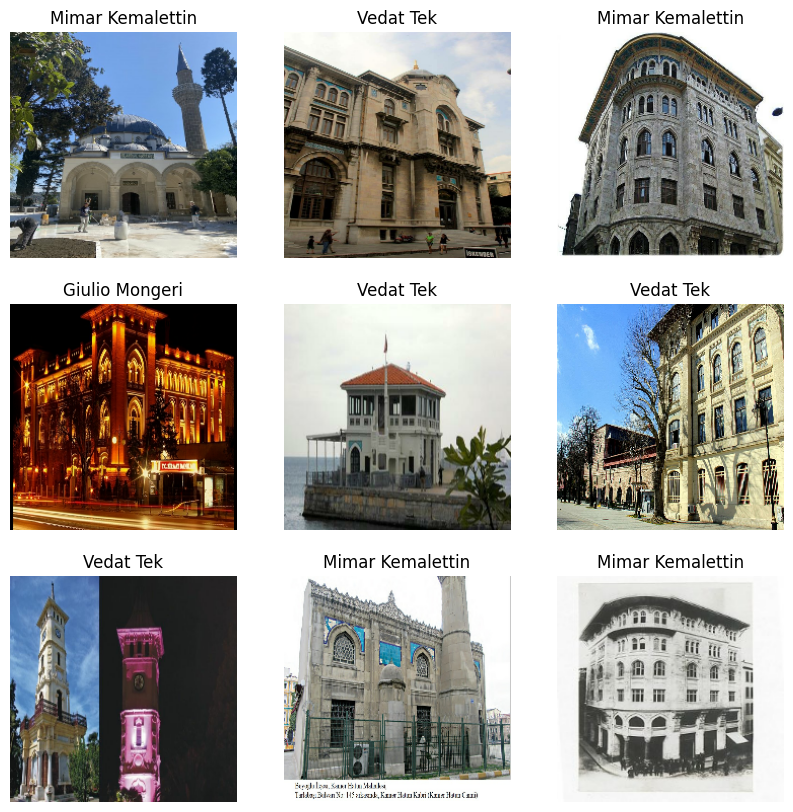

In [ ]:
# Keep the number of classes for for the softmax activation
num_classes = len(train_ds.class_names)
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
import matplotlib.pyplot as plt

def visualize_dataset(dataset, class_names):
    num_images_per_class = [0] * len(class_names)

    for _, labels in dataset:
        for label in labels:
            num_images_per_class[label] += 1

    # Create a bar plot showing the number of images per class
    plt.figure(figsize=(10, 8))
    bars = plt.bar(class_names, num_images_per_class, color='skyblue')

    plt.xlabel('Architects')
    plt.ylabel('Number of Images')
    plt.title(f'Number of Images per Class')
    plt.xticks(rotation=45)

    # Display numeric values on top of the bars
    for bar, num_images in zip(bars, num_images_per_class):
        plt.text(bar.get_x() + bar.get_width() / 2, num_images + 5, str(num_images),
                 ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

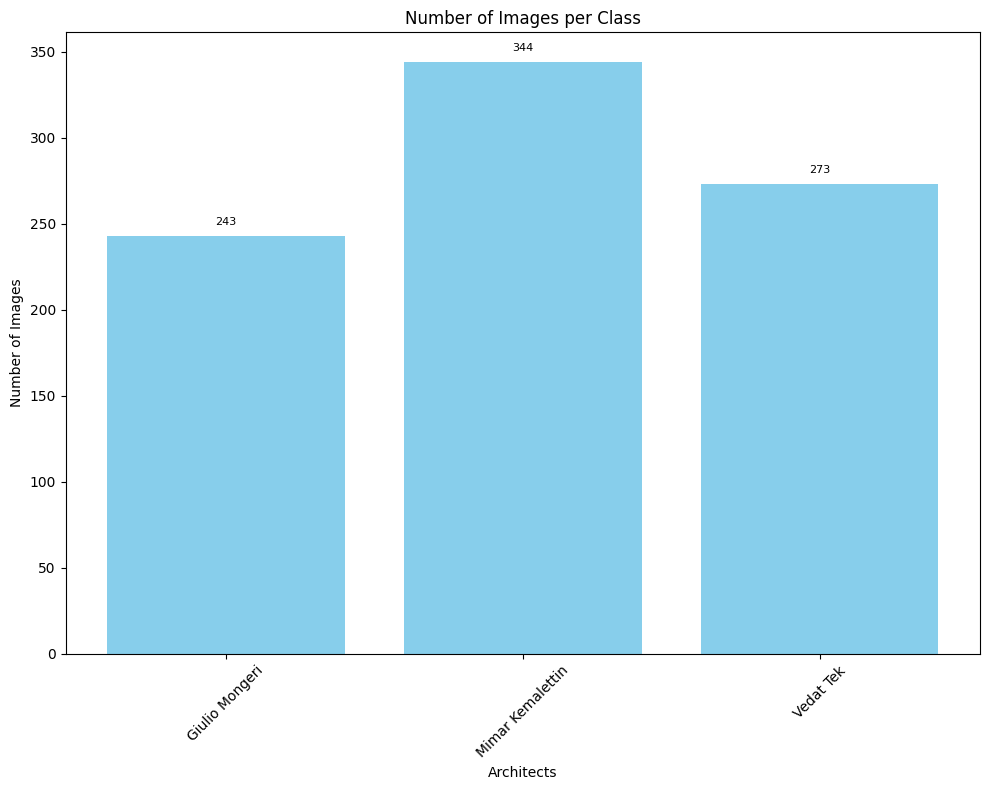

In [ ]:
visualize_dataset(train_ds, class_names)

# Data Preprocessing (Normalization & Augmentation)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Standardizes pixel values to the [0, 1] range
# Having features on a similar scale can help the gradient descent converge more quickly towards the minima
rescale = tf.keras.Sequential([
  Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  RandomFlip(
      "horizontal",
      input_shape=(img_height,img_width, 3)),
  RandomRotation(0.2),
  RandomZoom(0.1),
])

def prepare(ds, shuffle=False, augment=False):
  # Rescale all datasets.
  ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

  # Configure the dataset for performance
  # https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

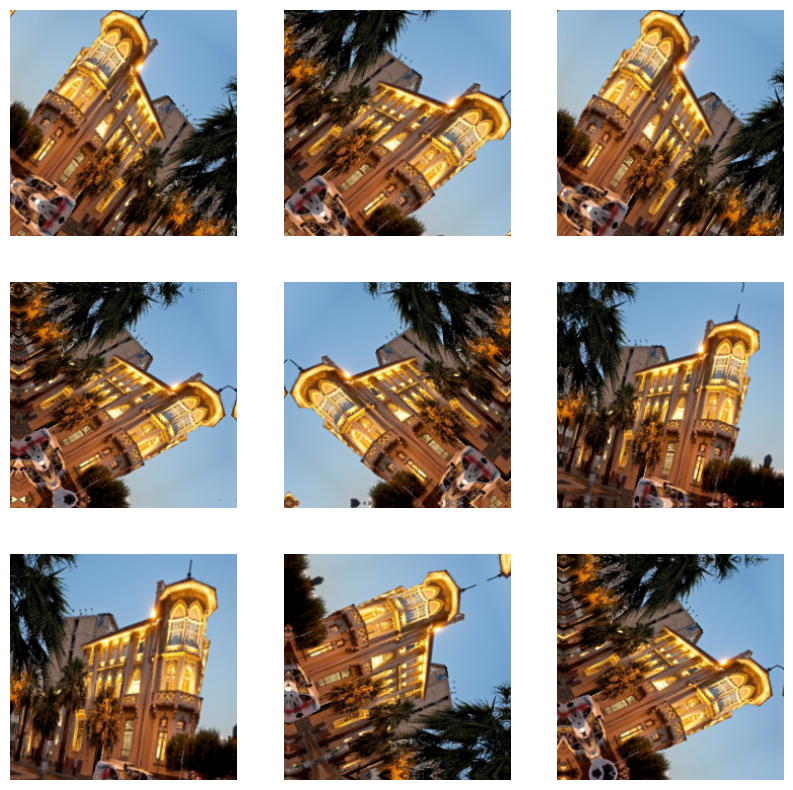

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    #augmented_images = data_augmentation.random_transform(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
train_aug_ds = prepare(train_ds, augment=True)
train_ds = prepare(train_ds)
val_ds = prepare(val_ds)

# Deep Learning Model

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_matrix(model, val_ds):
  # Get true labels from validation dataset
  true_labels = []
  for _, labels in val_ds:
      true_labels.extend(labels.numpy())

  # Make predictions using the validation dataset
  predicted_probs = model.predict(val_ds)
  predicted_labels = np.argmax(predicted_probs, axis=1)

  # Generating the confusion matrix
  cm = confusion_matrix(true_labels, predicted_labels)

  # Displaying the confusion matrix using seaborn heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

def plot_performance(history):
  # Accessing training/validation accuracies and losses
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(1, len(train_acc) + 1)

  # Plotting accuracy
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  # Plotting loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

epochs = 100
batch_size = 32

model_file_path = "saved_models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hd5f"
# model_file_path = "saved_models/weights-improvement-{epoch:02d}"

checkpoint = ModelCheckpoint(
    model_file_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    save_freq='epoch')

lr_reducer = ReduceLROnPlateau(
    factor=np.sqrt(0.1),
    cooldown=0,
    patience=5,
    min_lr=0.5e-6)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=15,
    verbose=1,
    mode='auto')

callbacks_list = [checkpoint, early_stop, lr_reducer]

## Training a Model from Scratch

### Experiment 1: VGG-16 Inspired Model

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()

epochs = 500
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/500
27/27 [==============================] - ETA: 0s - loss: 3.1076 - accuracy: 0.3221
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to saved_models/weights-improvement-01-0.40.hd5f
27/27 [==============================] - 18s 442ms/step - loss: 3.1076 - accuracy: 0.3221 - val_loss: 1.0899 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 2/500
27/27 [==============================] - ETA: 0s - loss: 1.0891 - accuracy: 0.4163
Epoch 2: val_accuracy did not improve from 0.40000
27/27 [==============================] - 15s 382ms/step - loss: 1.0891 - accuracy: 0.4163 - val_loss: 1.0848 - val_accuracy: 0.3953 - lr: 0.0010
Epoch 3/500
26/27 [===========================>..] - ETA: 0s - loss: 1.0582 - accuracy: 0.4435
Epoch 3: val_accuracy improved from 0.40000 to 0.44186, saving model to saved_models/weights-improvement-03-0.44.hd5f
27/27 [==============================] - 18s 549ms/step - loss: 1.0579 - accuracy: 0.4430 - val_loss: 1.0670 - val_accuracy: 0.4419 - lr: 0.0

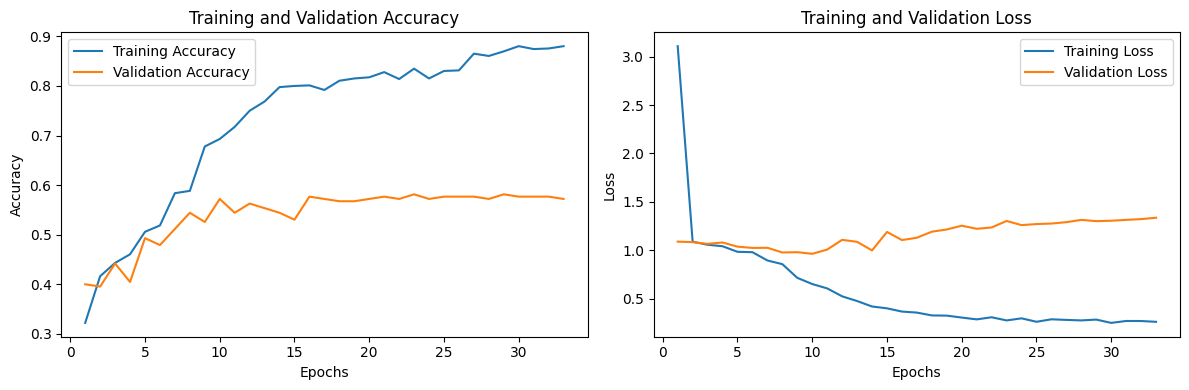

In [ ]:
plot_performance(history)

### Experiment 2: Decrease the Depth of the Model

In [ ]:
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

lr_reducer = ReduceLROnPlateau(
    factor=np.sqrt(0.1),
    cooldown=0,
    patience=5,
    min_lr=0.5e-6)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    restore_best_weights=True,
    min_delta=0,
    patience=20,
    verbose=1,
    mode='auto')

epochs = 100
batch_size = 32

history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=[early_stopping, lr_reducer])

Epoch 1/100
27/27 [==============================] - 17s 397ms/step - loss: 5.0412 - accuracy: 0.3477 - val_loss: 2.8719 - val_accuracy: 0.2419 - lr: 1.0000e-04
Epoch 2/100
27/27 [==============================] - 15s 451ms/step - loss: 1.5913 - accuracy: 0.4698 - val_loss: 1.4255 - val_accuracy: 0.4326 - lr: 1.0000e-04
Epoch 3/100
27/27 [==============================] - 14s 405ms/step - loss: 1.2068 - accuracy: 0.6116 - val_loss: 1.4881 - val_accuracy: 0.4233 - lr: 1.0000e-04
Epoch 4/100
27/27 [==============================] - 16s 453ms/step - loss: 1.0644 - accuracy: 0.6791 - val_loss: 1.3329 - val_accuracy: 0.4419 - lr: 1.0000e-04
Epoch 5/100
27/27 [==============================] - 15s 437ms/step - loss: 1.0282 - accuracy: 0.6849 - val_loss: 1.4848 - val_accuracy: 0.4419 - lr: 1.0000e-04
Epoch 6/100
27/27 [==============================] - 20s 650ms/step - loss: 0.8772 - accuracy: 0.7767 - val_loss: 1.2542 - val_accuracy: 0.5163 - lr: 1.0000e-04
Epoch 7/100
27/27 [===============

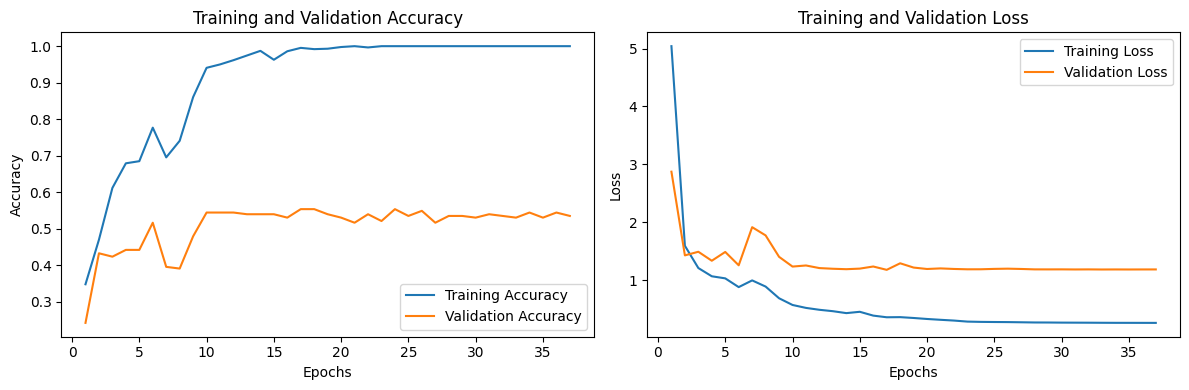

In [ ]:
plot_performance(history)

### Experiment 3: Add Dropout

In [ ]:
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_reducer = ReduceLROnPlateau(
    factor=np.sqrt(0.1),
    cooldown=0,
    patience=5,
    min_lr=0.5e-6)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    restore_best_weights=True,
    min_delta=0,
    patience=20,
    verbose=1,
    mode='auto')

epochs = 100
batch_size = 32

history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=[early_stopping, lr_reducer])

Epoch 1/100
27/27 [==============================] - 17s 404ms/step - loss: 20.4904 - accuracy: 0.3640 - val_loss: 18.5561 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 14s 418ms/step - loss: 6.5943 - accuracy: 0.4919 - val_loss: 12.6318 - val_accuracy: 0.3953 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 14s 393ms/step - loss: 5.5368 - accuracy: 0.5337 - val_loss: 9.9451 - val_accuracy: 0.4047 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 17s 464ms/step - loss: 4.9978 - accuracy: 0.5523 - val_loss: 8.7393 - val_accuracy: 0.4279 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 14s 416ms/step - loss: 4.5388 - accuracy: 0.5605 - val_loss: 7.9318 - val_accuracy: 0.4512 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 15s 411ms/step - loss: 4.2462 - accuracy: 0.5442 - val_loss: 6.6473 - val_accuracy: 0.4140 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 14

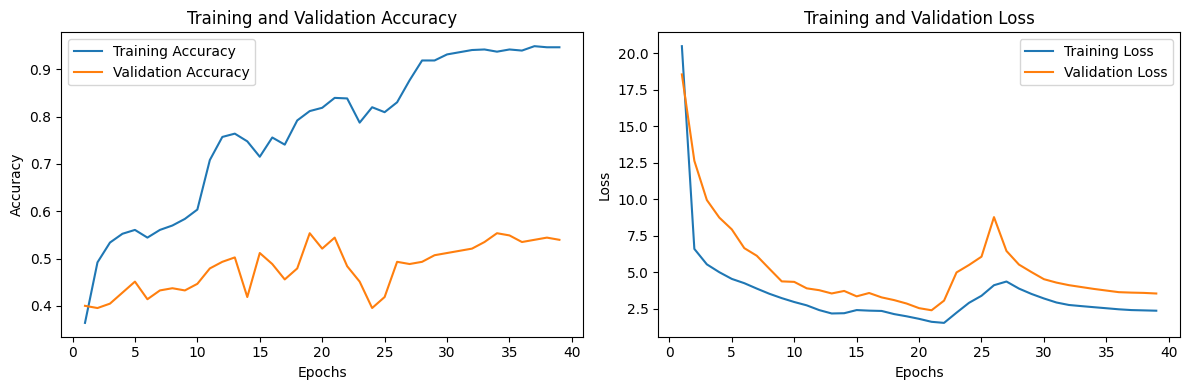

In [ ]:
plot_performance(history)

In [ ]:
plot_performance(history)

## Transfer Learning

 Transfer learning is a very good approach if we have less data for our problem statement.

### Feature Extraction

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

bottleneck_features_train = base_model.predict(train_ds)
bottleneck_features_val = base_model.predict(val_ds)

train_labels = []
for images, labels in train_ds:
    train_labels.extend(labels.numpy())

val_labels = []
for images, labels in val_ds:
    val_labels.extend(labels.numpy())

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

7/7 [==============================] - 8s 898ms/step


In [ ]:
bottleneck_features_train.shape
bottleneck_features_val.shape

(7, 7, 512)

In [ ]:
val_labels.shape

(215,)

In [ ]:
top_model = Sequential()
top_model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
top_model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
top_model.add(Dropout(0.5))
top_model.add(BatchNormalization())

top_model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
top_model.add(Dropout(0.5))
top_model.add(BatchNormalization())

top_model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
top_model.add(Dropout(0.5))
top_model.add(BatchNormalization())

top_model.add(Dense(num_classes, activation='softmax'))

top_model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])

history = top_model.fit(
    bottleneck_features_train, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(bottleneck_features_val, val_labels),
    callbacks=callbacks_list)

Epoch 1/100
22/27 [=======================>......] - ETA: 0s - loss: 1.4723 - accuracy: 0.3679
Epoch 1: val_accuracy did not improve from 0.41860
27/27 [==============================] - 4s 27ms/step - loss: 1.4646 - accuracy: 0.3616 - val_loss: 1.2949 - val_accuracy: 0.2744 - lr: 0.0010
Epoch 2/100
25/27 [==========================>...] - ETA: 0s - loss: 1.4310 - accuracy: 0.3350
Epoch 2: val_accuracy did not improve from 0.41860
27/27 [==============================] - 0s 8ms/step - loss: 1.4453 - accuracy: 0.3233 - val_loss: 1.1437 - val_accuracy: 0.3628 - lr: 0.0010
Epoch 3/100
25/27 [==========================>...] - ETA: 0s - loss: 1.3527 - accuracy: 0.3762
Epoch 3: val_accuracy did not improve from 0.41860
27/27 [==============================] - 0s 10ms/step - loss: 1.3659 - accuracy: 0.3733 - val_loss: 1.0796 - val_accuracy: 0.3953 - lr: 0.0010
Epoch 4/100
24/27 [=========================>....] - ETA: 0s - loss: 1.3676 - accuracy: 0.3294
Epoch 4: val_accuracy did not improve f

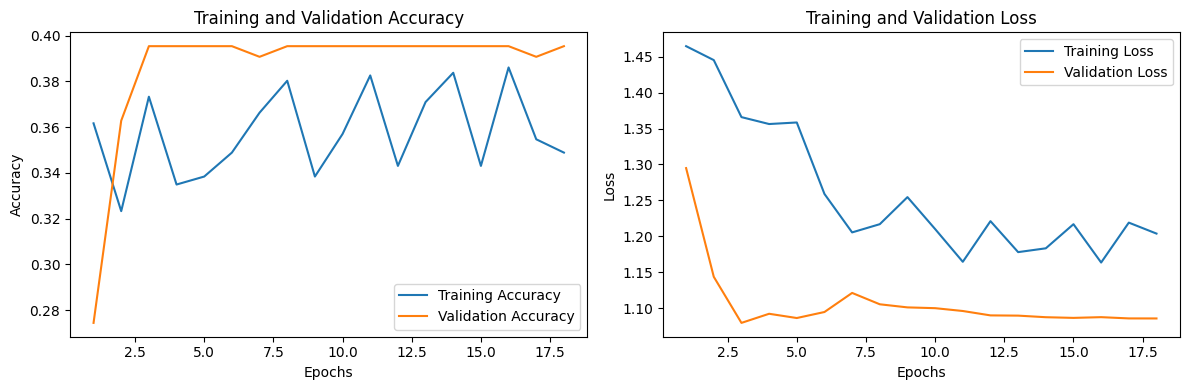

In [ ]:
plot_performance(history)

In [ ]:
top_model = Sequential()
top_model.add(Flatten(input_shape=(7, 7, 512)))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.4))
top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.4))
top_model.add(Dense(num_classes, activation='softmax'))

top_model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])

history = top_model.fit(
    bottleneck_features_train, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(bottleneck_features_val, val_labels),
    callbacks=callbacks_list)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               3211392   
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 3)                 387       
                                                                 
Total params: 3211779 (12.25 MB)
Trainable params: 3211779 (12.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
23/27 [========================>.....] - ETA: 0s - loss: 1.9027 - accuracy: 0.3519
Epoch 1: val_accuracy did not improve from 0.40000


### Exp: Default VGG

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

x = Flatten()(vgg_model.output)
prediction = Dense(num_classes, activation='softmax')(x)
transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])

transfer_history = transfer_model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

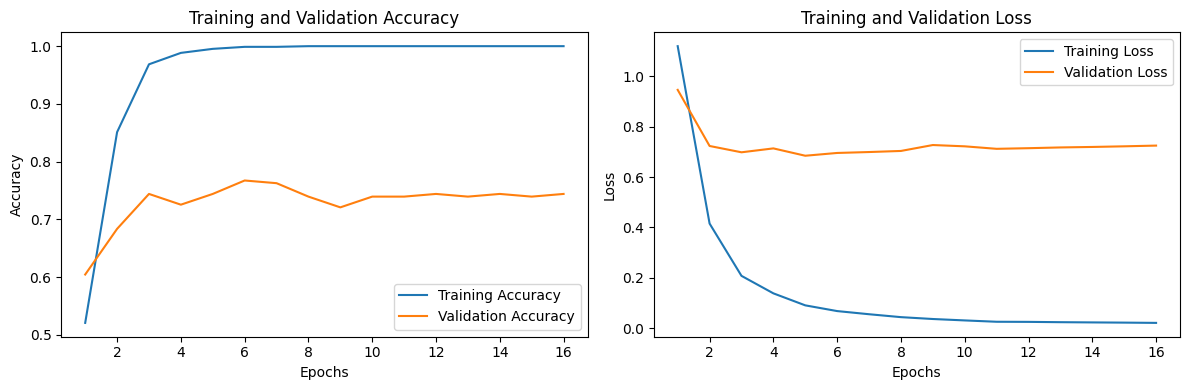

In [ ]:
plot_performance(transfer_history)

### Exp: Additional Dense Layer with L2 Regularizer and Following Dropout

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

x = Flatten()(vgg_model.layers[-1].output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
prediction = Dense(num_classes, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

transfer_history = transfer_model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 4.6903 - accuracy: 0.4500
Epoch 1: val_accuracy did not improve from 0.76744
27/27 [==============================] - 19s 492ms/step - loss: 4.6903 - accuracy: 0.4500 - val_loss: 2.5476 - val_accuracy: 0.6140 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 1.9717 - accuracy: 0.7477
Epoch 2: val_accuracy did not improve from 0.76744
27/27 [==============================] - 16s 478ms/step - loss: 1.9717 - accuracy: 0.7477 - val_loss: 1.8095 - val_accuracy: 0.6465 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 1.3726 - accuracy: 0.7930
Epoch 3: val_accuracy did not improve from 0.76744
27/27 [==============================] - 16s 487ms/step - loss: 1.3726 - accuracy: 0.7930 - val_loss: 1.5172 - val_accuracy: 0.7070 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - ETA: 0s - loss: 1.0314 - accuracy: 0.8907
Epoch 4: val_accuracy did not im

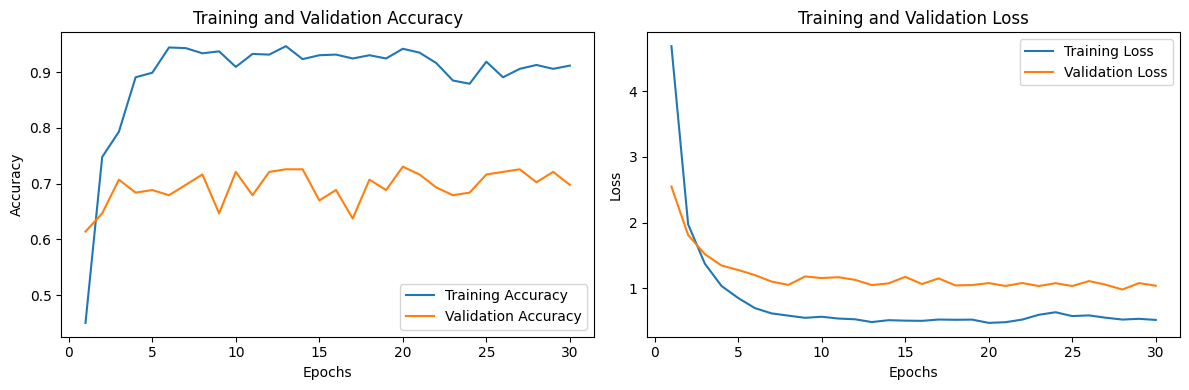

In [ ]:
plot_performance(transfer_history)

### Exp: Reduce the Dropout

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

# Adding regularization and dropout
x = Flatten()(vgg_model.layers[-1].output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
prediction = Dense(num_classes, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

transfer_history = transfer_model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 4.6139 - accuracy: 0.4581
Epoch 1: val_accuracy did not improve from 0.76744
27/27 [==============================] - 17s 479ms/step - loss: 4.6139 - accuracy: 0.4581 - val_loss: 2.4446 - val_accuracy: 0.5628 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 1.6981 - accuracy: 0.7942
Epoch 2: val_accuracy did not improve from 0.76744
27/27 [==============================] - 17s 509ms/step - loss: 1.6981 - accuracy: 0.7942 - val_loss: 1.6873 - val_accuracy: 0.6791 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 1.0830 - accuracy: 0.8930
Epoch 3: val_accuracy did not improve from 0.76744
27/27 [==============================] - 17s 499ms/step - loss: 1.0830 - accuracy: 0.8930 - val_loss: 1.3951 - val_accuracy: 0.6884 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - ETA: 0s - loss: 0.7778 - accuracy: 0.9442
Epoch 4: val_accuracy did not im

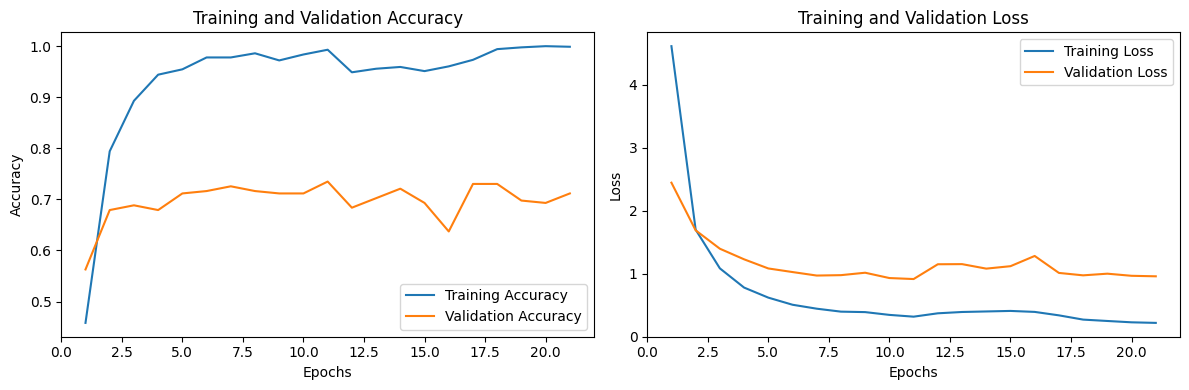

In [ ]:
plot_performance(transfer_history)

### Exp: Increase Width of the First Dense Layer

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

# Adding regularization and dropout
x = Flatten()(vgg_model.layers[-1].output)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
prediction = Dense(num_classes, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

transfer_history = transfer_model.fit(
    train_aug_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 9.9846 - accuracy: 0.3744 
Epoch 1: val_accuracy improved from -inf to 0.49302, saving model to saved_models/weights-improvement-01-0.49.hd5f
27/27 [==============================] - 84s 3s/step - loss: 9.9846 - accuracy: 0.3744 - val_loss: 4.2610 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 3.6606 - accuracy: 0.4570
Epoch 2: val_accuracy improved from 0.49302 to 0.50233, saving model to saved_models/weights-improvement-02-0.50.hd5f
27/27 [==============================] - 24s 776ms/step - loss: 3.6606 - accuracy: 0.4570 - val_loss: 2.7966 - val_accuracy: 0.5023 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 2.4708 - accuracy: 0.4814
Epoch 3: val_accuracy did not improve from 0.50233
27/27 [==============================] - 21s 652ms/step - loss: 2.4708 - accuracy: 0.4814 - val_loss: 2.1302 - val_accuracy: 0.4977 - lr: 0.001

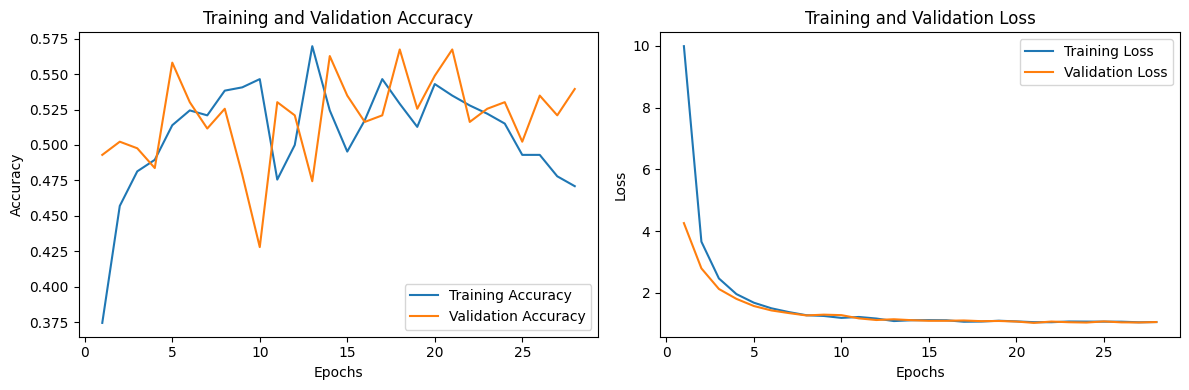

In [ ]:
plot_performance(transfer_history)

### Exp: Add Second Dense Layer ***

In [ ]:
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg_model.layers:
 layer.trainable = False

x = Flatten()(vgg_model.layers[-1].output)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
prediction = Dense(num_classes, activation='softmax')(x)

transfer_model = Model(inputs=vgg_model.input, outputs=prediction)

transfer_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

transfer_history = transfer_model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=callbacks_list)

58889256/58889256 [==============================] - 0s 0us/step


Epoch 1/100
27/27 [==============================] - 24s 634ms/step - loss: 6.3089 - accuracy: 0.3802 - val_loss: 4.1597 - val_accuracy: 0.4884 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 18s 538ms/step - loss: 3.6594 - accuracy: 0.5093 - val_loss: 3.0471 - val_accuracy: 0.6186 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 16s 489ms/step - loss: 2.6443 - accuracy: 0.6140 - val_loss: 2.3716 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 17s 509ms/step - loss: 2.1088 - accuracy: 0.6814 - val_loss: 2.0263 - val_accuracy: 0.6930 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 18s 537ms/step - loss: 1.6900 - accuracy: 0.7814 - val_loss: 1.7837 - val_accuracy: 0.6884 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 16s 462ms/step - loss: 1.5509 - accuracy: 0.7698 - val_loss: 1.6384 - val_accuracy: 0.6977 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 16s 4

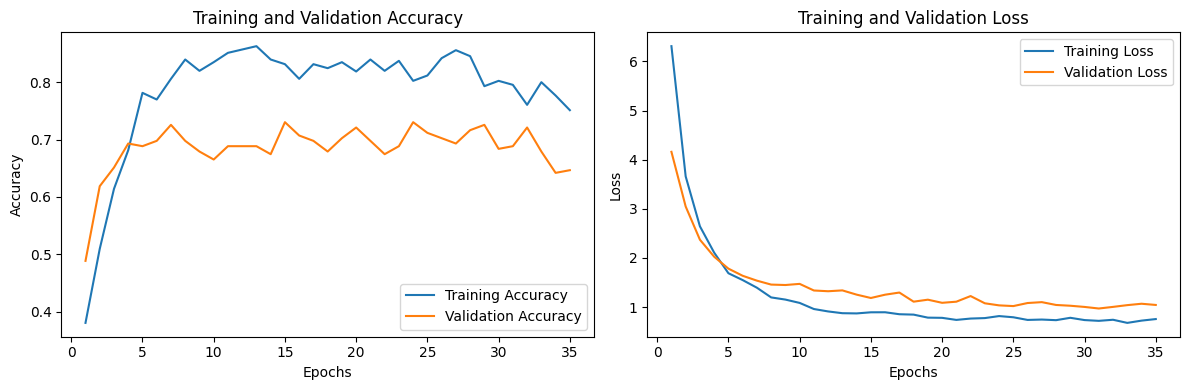

In [ ]:
plot_performance(transfer_history)

loss: 0.8954 - accuracy: 0.8314 - val_loss: 1.1865 - val_accuracy: 0.7302

### Exp: New Type of NN

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the base_model
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=[early_stop, lr_reducer])

Model: "model_8"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         Y          
                                                                            
 vgg16 (Functional)          (None, 7, 7, 512)         1471468   N          
                                                       8                    
                                                                            
 global_average_pooling2d_7  (None, 512)               0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_7 (Dropout)         (None, 512)               0         Y          
                                                                            
 dense_8 (Dense)             (None, 3)                 1539

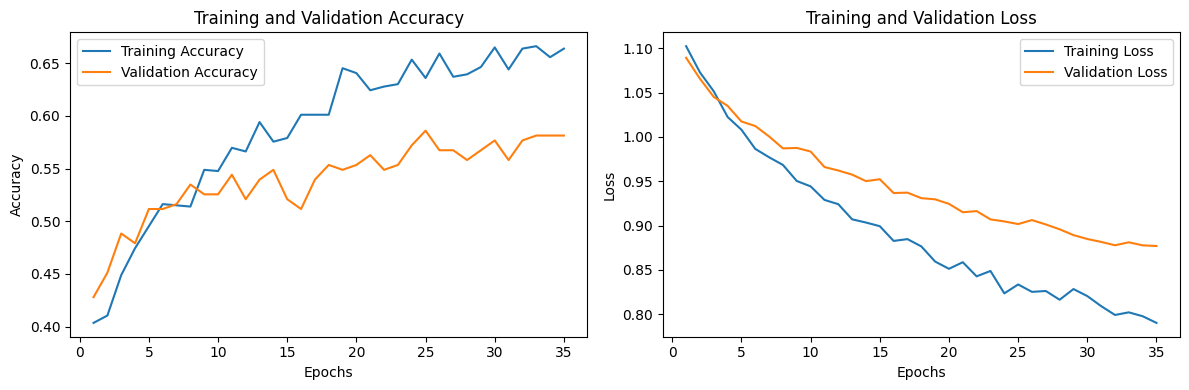

In [ ]:
plot_performance(history)

### Exp: New Type of NN (Increase the Depth)

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the base_model
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=[early_stop, lr_reducer])

In [ ]:
plot_performance(history)

## Fine-tuning

# Predict on new data

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to Giulio Mongeri with a 57.61 percent confidence.


# Save the Model

In [ ]:
from tensorflow.keras.models import load_model

model_dir = os.path.join('models','arch_classifier.h5')

In [ ]:
model.save(model_dir)

In [ ]:
# model = load_model(os.path.join('models','arch_classifier.h5'))

# K-means Clustering

In [ ]:
def extract_features(feature_extractor, data):
  return feature_extractor.predict(data)

In [ ]:
# remove the augmentation layer
feature_extractor = Sequential(model.layers[1:-1])

train_features = extract_features(feature_extractor, train_ds)
val_features = extract_features(feature_extractor, val_ds)

features = np.concatenate((train_features, val_features))
# features = np.array(train_features + val_features)

In [ ]:
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Concatenate the labels
labels = np.concatenate([train_labels, val_labels], axis=0)

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
reduced_features_pca = pca.fit_transform(features)

In [ ]:
from sklearn.cluster import KMeans

# Apply k-means clustering
num_clusters = num_classes # FIND A GOOD NUMBER HERE

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clustered_pca = kmeans.fit_predict(reduced_features_pca)

centroids_pca = kmeans.cluster_centers_

In [ ]:
# Plot the 2D representation with centroids
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    # Create a boolean array where each element is True if the corresponding label is equal to i, and False otherwise.
    cluster_points = reduced_features_pca[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=class_name)

# Plot centroids
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='x', s=200, color='black', label='Centroids')

plt.title('Visualized on PCA 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
reduced_features_tsne = tsne.fit_transform(features)

In [ ]:
# Apply k-means clustering
num_clusters = num_classes # FIND A GOOD NUMBER HERE

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clustered_tsne = kmeans.fit_predict(reduced_features_tsne)

# Transform cluster centers using the same PCA object
centroids_tsne = kmeans.cluster_centers_

In [ ]:
# Plot the 2D representation with centroids
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    # Create a boolean array where each element is True if the corresponding label is equal to i, and False otherwise.
    cluster_points = reduced_features_tsne[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=class_name)

# Plot centroids
plt.scatter(centroids_tsne[:, 0], centroids_tsne[:, 1], marker='x', s=200, color='black', label='Centroids')

plt.title('Visualized on TSNE 2D')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Plot the 2D representation with centroids
plt.figure(figsize=(22, 10))

plt.subplot(1, 2, 1)
plt.title('Visualized on PCA 2D')

for i, class_name in enumerate(class_names):
    cluster_points = reduced_features_pca[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=class_name)

plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='x', s=200, color='black', label='Centroids')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.title('Visualized on TSNE 2D')

for i, class_name in enumerate(class_names):
    cluster_points = reduced_features_tsne[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=class_name)

plt.scatter(centroids_tsne[:, 0], centroids_tsne[:, 1], marker='x', s=200, color='black', label='Centroids')
plt.legend(loc='upper right')

plt.suptitle('Comparing clustering result when visualized using PCA2D vs. TSNE2D')
plt.show()